In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [14]:
spark = SparkSession.builder.appName("CustomerChurnPrediction").getOrCreate()

In [15]:
data = spark.read.csv(r"C:\Users\HP\OneDrive\Desktop\Big Data\telecom_churn_final_data.csv", header=True, inferSchema=True)

In [16]:
data.show(5)

+---+------+-------------+-------+------+------------+-------------+---------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
| ID|Gender|SeniorCitizen|Married|Tenure|PhoneService|MultipleLines|InternetService|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+---+------+-------------+-------+------+------------+-------------+---------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|  0|Female|            0|    Yes|     1|          No|           No|            DSL|         No|         No|             No|Month-to-month|             Yes|    Electronic check|         29.85|       29.85|   No|
|  1|  Male|            0|     No|    34|         Yes|           No|            DSL|         No|         No|             No|      One year|             

In [17]:
# Step 3: Handle categorical variables
categorical_columns = ["Gender", "Married", "PhoneService", "MultipleLines", "InternetService", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod", "Churn"]

# Drop any existing indexed columns if they exist
for column in [col + "Index" for col in categorical_columns]:
    if column in data.columns:
        data = data.drop(column)

# Create StringIndexer for each categorical column and transform the data
for column in categorical_columns:
    indexer = StringIndexer(inputCol=column, outputCol=column + "Index")
    data = indexer.fit(data).transform(data)

# Prepare the feature columns including the new indexed columns
feature_cols = ["SeniorCitizen", "MarriedIndex", "Tenure", "PhoneServiceIndex", "MultipleLinesIndex", "TechSupportIndex", "StreamingTVIndex", "StreamingMoviesIndex", "MonthlyCharges", "TotalCharges", "GenderIndex", "InternetServiceIndex", "ContractIndex", "PaymentMethodIndex"]

# Create the feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

In [18]:
# Prepare the final dataset
final_data = data.select("features", "ChurnIndex")


In [19]:
# Step 6: Split the Data
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)


In [20]:
# Step 7: Train the Model
lr = LogisticRegression(labelCol="ChurnIndex", featuresCol="features")
lr_model = lr.fit(train_data)

In [21]:
# Step 8: Make Predictions
predictions = lr_model.transform(test_data)
predictions.select("features", "ChurnIndex", "prediction").show(5)

+--------------------+----------+----------+
|            features|ChurnIndex|prediction|
+--------------------+----------+----------+
|(14,[0,1,2,6,7,8,...|       1.0|       1.0|
|(14,[0,2,6,7,8,9,...|       0.0|       1.0|
|(14,[1,2,3,6,7,8,...|       0.0|       1.0|
|(14,[1,2,3,8,9,10...|       0.0|       0.0|
|(14,[1,2,4,8,9,10...|       0.0|       0.0|
+--------------------+----------+----------+
only showing top 5 rows



In [22]:
# Step 8: Make Predictions
predictions = lr_model.transform(test_data)

# Select relevant columns to view
predictions.select("features", "ChurnIndex", "prediction").show(10)

# Optionally, if we want to see the predicted and actual values in a more readable format
predictions.select("ChurnIndex", "prediction").show(10)  # Displaying actual and predicted values

+--------------------+----------+----------+
|            features|ChurnIndex|prediction|
+--------------------+----------+----------+
|(14,[0,1,2,6,7,8,...|       1.0|       1.0|
|(14,[0,2,6,7,8,9,...|       0.0|       1.0|
|(14,[1,2,3,6,7,8,...|       0.0|       1.0|
|(14,[1,2,3,8,9,10...|       0.0|       0.0|
|(14,[1,2,4,8,9,10...|       0.0|       0.0|
|(14,[1,2,5,8,9,12...|       0.0|       0.0|
|(14,[1,2,8,9,10,1...|       0.0|       0.0|
|(14,[1,2,8,9,11,1...|       0.0|       0.0|
|(14,[2,3,8,9,12,1...|       0.0|       0.0|
|(14,[2,3,8,9,13],...|       0.0|       0.0|
+--------------------+----------+----------+
only showing top 10 rows

+----------+----------+
|ChurnIndex|prediction|
+----------+----------+
|       1.0|       1.0|
|       0.0|       1.0|
|       0.0|       1.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
+----------+----------+
only sho

In [23]:
# Step 9: Evaluate the Model
evaluator = BinaryClassificationEvaluator(labelCol="ChurnIndex", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Area Under ROC: {auc}")

Area Under ROC: 0.8947368421052632


In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Step 10: Evaluate the Model
evaluator = BinaryClassificationEvaluator(labelCol="ChurnIndex", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Area Under ROC: {auc}")

# Calculate Accuracy
# Create a MulticlassClassificationEvaluator
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="ChurnIndex", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Area Under ROC: 0.8947368421052632
Accuracy: 0.8181818181818182


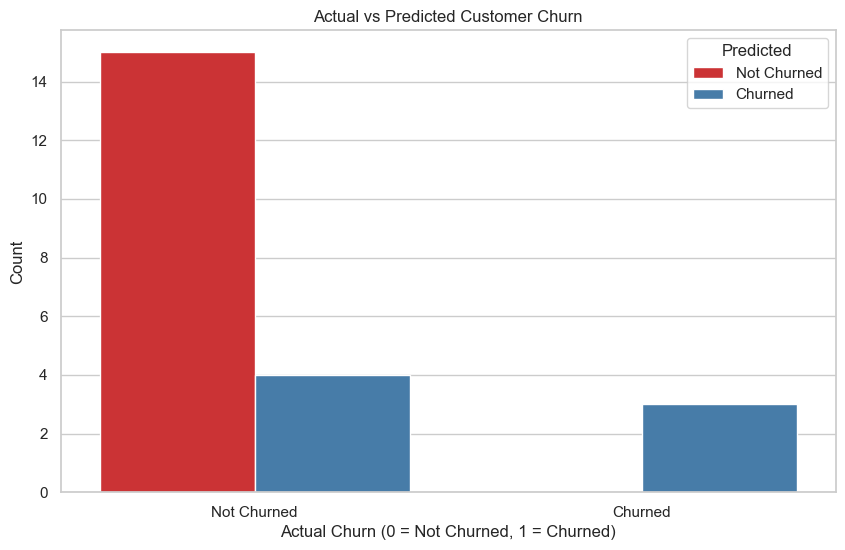

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions DataFrame to Pandas DataFrame
predictions_pd = predictions.select("ChurnIndex", "prediction").toPandas()

# Set the style for the plots
sns.set(style="whitegrid")

# Create a countplot for actual vs predicted values
plt.figure(figsize=(10, 6))
sns.countplot(data=predictions_pd, x='ChurnIndex', hue='prediction', palette='Set1')

# Add labels and title
plt.title('Actual vs Predicted Customer Churn')
plt.xlabel('Actual Churn (0 = Not Churned, 1 = Churned)')
plt.ylabel('Count')
plt.legend(title='Predicted', labels=['Not Churned', 'Churned'])
plt.xticks([0, 1], ['Not Churned', 'Churned'])

# Show the plot
plt.show()

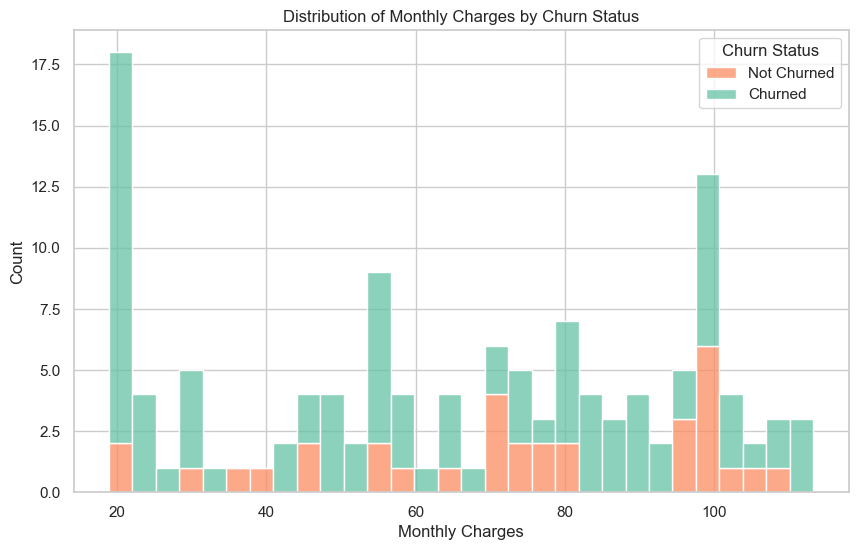

In [27]:
#Distribution of monthly charges 
# Assuming `data` is the original DataFrame containing 'MonthlyCharges' and 'Churn'
data_pd = data.select("MonthlyCharges", "ChurnIndex").toPandas()  # Convert to Pandas DataFrame

plt.figure(figsize=(10, 6))
sns.histplot(data=data_pd, x='MonthlyCharges', hue='ChurnIndex', multiple="stack", bins=30, palette='Set2')
plt.title('Distribution of Monthly Charges by Churn Status')
plt.xlabel('Monthly Charges')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Not Churned', 'Churned'])
plt.show()

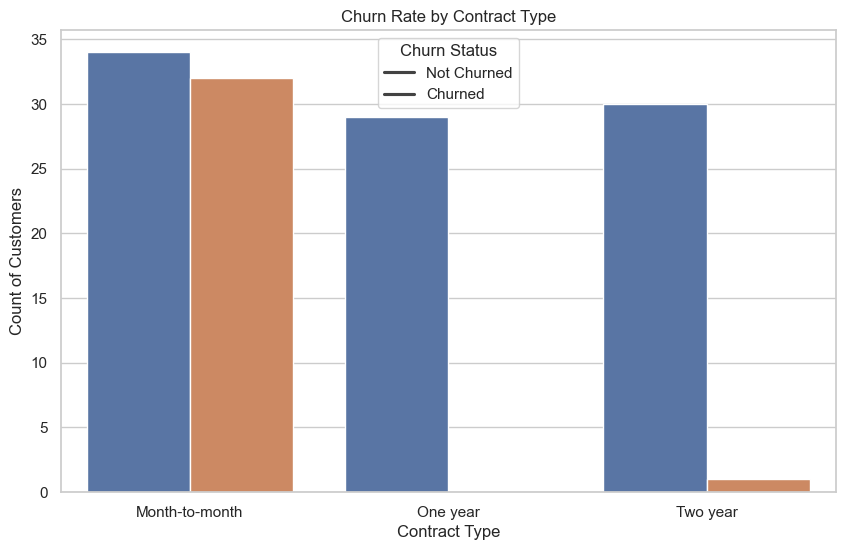

In [28]:
#Churn rate by contract type 
contract_data = data.groupBy("Contract", "ChurnIndex").count().toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=contract_data, x='Contract', y='count', hue='ChurnIndex')
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count of Customers')
plt.legend(title='Churn Status', labels=['Not Churned', 'Churned'])
plt.show()

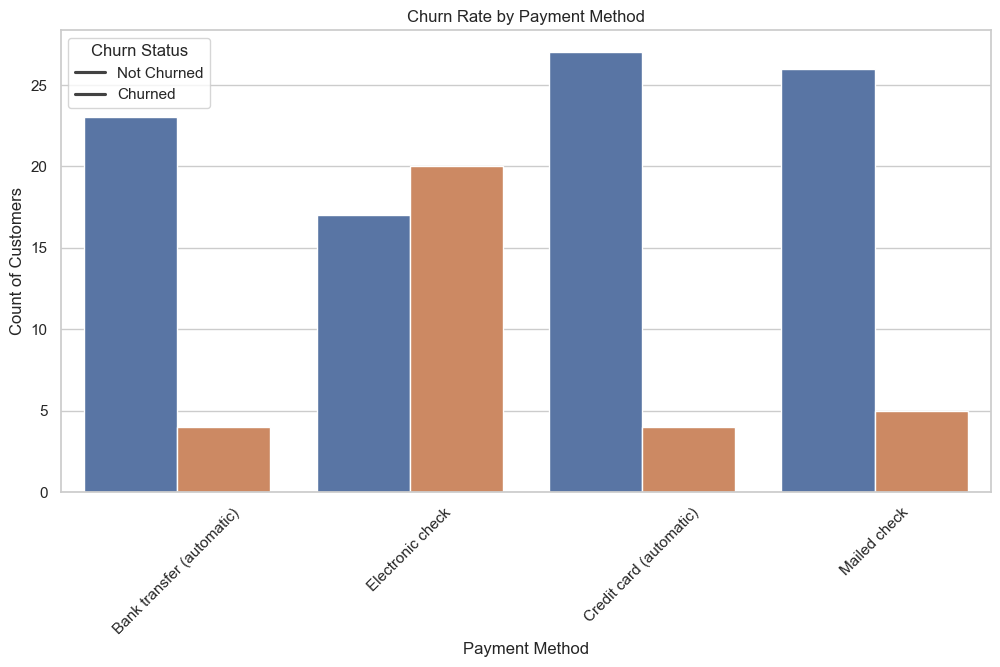

In [29]:
#Churn rate by payment method
payment_data = data.groupBy("PaymentMethod", "ChurnIndex").count().toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=payment_data, x='PaymentMethod', y='count', hue='ChurnIndex')
plt.title('Churn Rate by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Count of Customers')
plt.legend(title='Churn Status', labels=['Not Churned', 'Churned'])
plt.xticks(rotation=45)
plt.show()

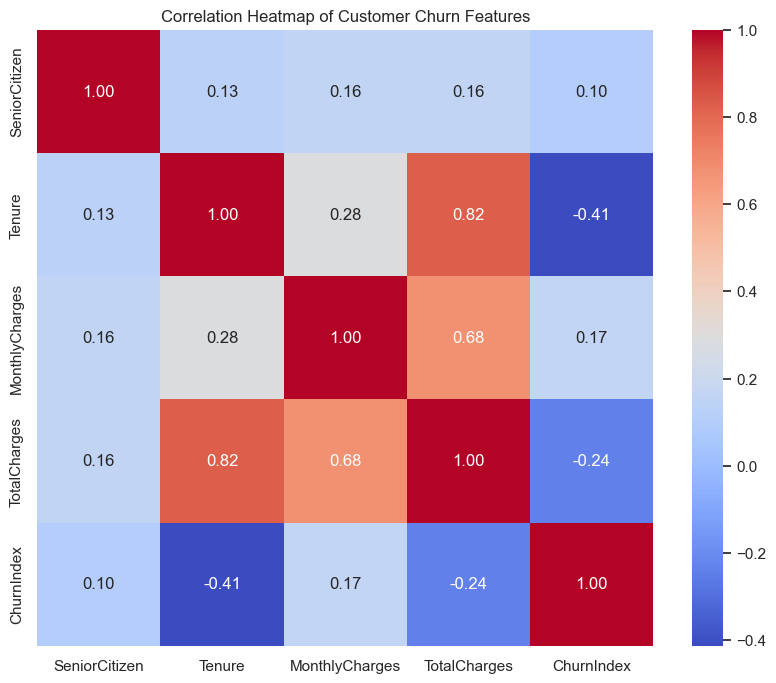

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant numerical features from the original DataFrame
# Make sure to replace 'data' with the name of your original DataFrame
feature_columns = ['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges', 'ChurnIndex']
correlation_data = data.select(feature_columns).toPandas()

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Add titles and labels
plt.title('Correlation Heatmap of Customer Churn Features')
plt.show()